### https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9762926

In [1]:
import json
import random
import os
import pickle
import time
import shutil
import sys
import uuid
from collections import defaultdict
from datetime import timedelta
from glob import glob
from itertools import product
from pyspark.sql import functions as sf
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.storagelevel import StorageLevel
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score

import igraph as ig
import leidenalg as la
import numpy as np
import pandas as pd

import settings as s
from common import get_weights
from communities import get_communities_spark
from features import generate_features_spark, generate_features_udf_wrapper, SCHEMA_FEAT_UDF

%load_ext autoreload
%autoreload 2

Checking whether there is an H2O instance running at http://localhost:54321.

/Users/ut77bo/miniconda3/envs/redirect/lib/python3.11/site-packages/h2o/backend/connection.py:390: UserWarning: Proxy is defined in the environment: http_proxy. This may interfere with your H2O Connection.
  warn("Proxy is defined in the environment: %s. "
/Users/ut77bo/miniconda3/envs/redirect/lib/python3.11/site-packages/h2o/backend/connection.py:390: UserWarning: Proxy is defined in the environment: HTTP_PROXY. This may interfere with your H2O Connection.
  warn("Proxy is defined in the environment: %s. "


.... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.15" 2025-04-15; OpenJDK Runtime Environment Homebrew (build 17.0.15+0); OpenJDK 64-Bit Server VM Homebrew (build 17.0.15+0, mixed mode, sharing)
  Starting server from /Users/ut77bo/miniconda3/envs/redirect/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/6y/nlg4qbl97fv9p4s5lxyqxgxh0000gp/T/tmph5vxne90
  JVM stdout: /var/folders/6y/nlg4qbl97fv9p4s5lxyqxgxh0000gp/T/tmph5vxne90/h2o_ut77bo_started_from_python.out
  JVM stderr: /var/folders/6y/nlg4qbl97fv9p4s5lxyqxgxh0000gp/T/tmph5vxne90/h2o_ut77bo_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Amsterdam
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,3 months and 27 days
H2O_cluster_name:,H2O_from_python_ut77bo_m4z4cb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,9 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [2]:
if (
    sys.version_info.major,
    sys.version_info.minor,
    sys.version_info.micro,
) != (3, 11, 8):
    raise EnvironmentError(
        "Only runs efficiently on Python 3.11.8 (Tested on: Conda 24.1.2 | Apple M3 Pro)"
    )

In [3]:
SPARK_CONF = [
    ("spark.driver.memory", "32g"),
    ("spark.worker.memory", "32g"),
    ("spark.driver.maxResultSize", "32g"),
    ("spark.driver.bindAddress", "127.0.0.1"),
    ("spark.sql.execution.arrow.pyspark.enabled", "true"),
    ("spark.network.timeout", "600s"),
    ("spark.sql.autoBroadcastJoinThreshold", -1)
]

shutil.rmtree("artifacts", ignore_errors=True)
spark = (
    SparkSession.builder.appName("testing")
    .config(conf=SparkConf().setAll(SPARK_CONF))
    .getOrCreate()
)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/25 15:07:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/07/25 15:07:14 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
data = pd.read_csv("./data/Libra_bank_3months_graph/data.csv")
rename = {
    "id_source": "source",
    "id_destination": "target",
    "cum_amount": "amount",
    "nr_transactions": "num_transactions",
    "nr_alerts": "alerts_count",
    "nr_reports": "reports_count",
}

data = data.rename(columns=rename)
data.loc[:, "source_"] = (
    data.loc[:, "source"].astype(str).apply(lambda x: f"nid-{int(x)}")
)
data.loc[:, "target_"] = (
    data.loc[:, "target"].astype(str).apply(lambda x: f"nid-{int(x)}")
)
del data["source"]
del data["target"]
data = data.rename(
    columns={
        "source_": "source",
        "target_": "target",
    }
).loc[:, ["source", "target", "amount", "num_transactions", "alerts_count", "reports_count"]]

In [5]:
nodes_data = pd.DataFrame(index=sorted(set(data["source"].tolist() + data["target"].tolist())))
nodes_data.index.name = "key"

w_alerts = int(data["alerts_count"].sum() * 2)
w_reports = int(data["reports_count"].sum() * 2)

w_alerts_source = data[data["alerts_count"] > 0].groupby("source").agg({"alerts_count": "sum"}).to_dict()["alerts_count"]
w_alerts_target = data[data["alerts_count"] > 0].groupby("target").agg({"alerts_count": "sum"}).to_dict()["alerts_count"]

w_reports_source = data[data["reports_count"] > 0].groupby("source").agg({"reports_count": "sum"}).to_dict()["reports_count"]
w_reports_target = data[data["reports_count"] > 0].groupby("target").agg({"reports_count": "sum"}).to_dict()["reports_count"]

nodes_data.loc[:, "alert_weight"] = nodes_data.index.map(
    lambda x: (w_alerts_source.get(x, 0) + w_alerts_target.get(x, 0)) / w_alerts
)
nodes_data.loc[:, "report_weight"] = nodes_data.index.map(
    lambda x: (w_reports_source.get(x, 0) + w_reports_target.get(x, 0)) / w_reports
)

In [6]:
total_nodes = nodes_data.shape[0]
perc_point_1_cnt = round(total_nodes * (0.1 / 100))
perc_point_2_cnt = round(total_nodes * (0.2 / 100))
perc_point_5_cnt = round(total_nodes * (0.5 / 100))
perc_1_cnt = round(total_nodes * (1 / 100))
perc_10_cnt = round(total_nodes * (10 / 100))
perc_20_cnt = round(total_nodes * (20 / 100))
perc_30_cnt = round(total_nodes * (30 / 100))
perc_40_cnt = round(total_nodes * (40 / 100))
perc_50_cnt = round(total_nodes * (50 / 100))
perc_75_cnt = round(total_nodes * (75 / 100))
print(total_nodes, perc_point_1_cnt, perc_point_2_cnt, perc_point_5_cnt, perc_1_cnt)

385100 385 770 1926 3851


In [110]:
%%time

candidates = nodes_data.index.tolist()
data_in_scope = data.copy(deep=True)
data_in_scope = data_in_scope.set_index(["source", "target"]).join(
    get_weights(data_in_scope).set_index(["source", "target"]), how="left"
).reset_index()
data_in_scope.loc[:, "amount_weighted"] = (
    data_in_scope.loc[:, "amount"] * 
    (data_in_scope.loc[:, "weight"] / data_in_scope.loc[:, "weight"].max())
)

%run model.ipynb

anomalies_main = anomalies.copy(deep=True)

In [111]:
# %%time

# import h2o
# from h2o.estimators import H2OIsolationForestEstimator
# h2o.init()

# h2o.display.toggle_user_tips(on=False)

# column_types = ["numeric" for k in all_features.columns]
# h2o_frame = h2o.H2OFrame(all_features.values.tolist(), column_names=all_features.columns.tolist(), column_types=column_types)

# model = H2OIsolationForestEstimator(max_depth=0, ntrees=10_000, sample_size=256)
# model.train(training_frame=h2o_frame)
# score = model.predict(h2o_frame).as_data_frame(use_pandas=True)

# anomalies = all_features.loc[:, []]
# anomalies.loc[:, "anomaly_score"] = (-score["predict"]).tolist()
# anomalies = anomalies.sort_values("anomaly_score", ascending=True)
# anomalies = anomalies.join(nodes_data)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
isolationforest Model Build progress: |██████████████████████████████████████████| (done) 100%
isolationforest prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/ut77bo/miniconda3/envs/redirect/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


CPU times: user 15.8 s, sys: 1.45 s, total: 17.3 s
Wall time: 22min 35s


In [118]:
graph_global = ig.Graph.DataFrame(data[["source", "target"]], use_vids=False, directed=True)

In [119]:
def add_predicted_alert_weight(anomalies_input, perc_count_in):
    anomalies_perc_x = anomalies_input.copy(deep=True)
    index = anomalies_perc_x.head(perc_count_in).index.tolist()
    anomalies_perc_x = anomalies_perc_x.loc[index, :]
    anomalies_perc_x.loc[:, "predicted_alert_weight"] = anomalies_perc_x.loc[:, "alert_weight"]
    anomalies_perc_x.loc[:, "predicted_report_weight"] = anomalies_perc_x.loc[:, "report_weight"]
    return anomalies_perc_x

In [120]:
communities_1_hop_dict = dict(communities_1_hop)

comms_1_hop_0_1_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies_main, perc_point_1_cnt).index]
comms_1_hop_0_2_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies_main, perc_point_2_cnt).index]
comms_1_hop_0_5_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies_main, perc_point_5_cnt).index]
comms_1_hop_1_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies_main, perc_1_cnt).index]

sizes_1_hop_0_1_perc = [len(x) for x in comms_1_hop_0_1_perc]
sizes_1_hop_0_2_perc = [len(x) for x in comms_1_hop_0_2_perc]
sizes_1_hop_0_5_perc = [len(x) for x in comms_1_hop_0_5_perc]
sizes_1_hop_1_perc = [len(x) for x in comms_1_hop_1_perc]

sizes_edge_1_hop_0_1_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_0_1_perc]
sizes_edge_1_hop_0_2_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_0_2_perc]
sizes_edge_1_hop_0_5_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_0_5_perc]
sizes_edge_1_hop_1_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_1_perc]

tpr = np.cumsum(add_predicted_alert_weight(anomalies_main, perc_1_cnt)["predicted_alert_weight"]).values
tpr_report = np.cumsum(add_predicted_alert_weight(anomalies_main, perc_1_cnt)["predicted_report_weight"]).values

results = [{
    "rectify_perc": 1.0,
    "leiden_size_max": np.max(sizes_leiden),
    "leiden_size_mean": np.mean(sizes_leiden),
    "leiden_size_median": np.median(sizes_leiden),
    "1_hop_size_max": np.max(sizes_1_hop),
    "1_hop_size_mean": np.mean(sizes_1_hop),
    "1_hop_size_median": np.median(sizes_1_hop),
    "0.1%": add_predicted_alert_weight(anomalies_main, perc_point_1_cnt)["predicted_alert_weight"].sum(),
    "0.2%": add_predicted_alert_weight(anomalies_main, perc_point_2_cnt)["predicted_alert_weight"].sum(),
    "0.5%": add_predicted_alert_weight(anomalies_main, perc_point_5_cnt)["predicted_alert_weight"].sum(),
    "1%": add_predicted_alert_weight(anomalies_main, perc_1_cnt)["predicted_alert_weight"].sum(),
    "tpr_1%": tpr,
    "tpr_auc_1%": np.mean(tpr),
    "report_0.1%": add_predicted_alert_weight(anomalies_main, perc_point_1_cnt)["predicted_report_weight"].sum(),
    "report_0.2%": add_predicted_alert_weight(anomalies_main, perc_point_2_cnt)["predicted_report_weight"].sum(),
    "report_0.5%": add_predicted_alert_weight(anomalies_main, perc_point_5_cnt)["predicted_report_weight"].sum(),
    "report_1%": add_predicted_alert_weight(anomalies_main, perc_1_cnt)["predicted_report_weight"].sum(),
    "tpr_report_1%": tpr_report,
    "tpr_report_auc_1%": np.mean(tpr_report),
    "max_1_hop_0_1_perc": np.max(sizes_1_hop_0_1_perc),
    "max_1_hop_0_2_perc": np.max(sizes_1_hop_0_2_perc),
    "max_1_hop_0_5_perc": np.max(sizes_1_hop_0_5_perc),
    "max_1_hop_1_perc": np.max(sizes_1_hop_1_perc),
    "mean_1_hop_0_1_perc": np.mean(sizes_1_hop_0_1_perc),
    "mean_1_hop_0_2_perc": np.mean(sizes_1_hop_0_2_perc),
    "mean_1_hop_0_5_perc": np.mean(sizes_1_hop_0_5_perc),
    "mean_1_hop_1_perc": np.mean(sizes_1_hop_1_perc),
    "median_1_hop_0_1_perc": np.median(sizes_1_hop_0_1_perc),
    "median_1_hop_0_2_perc": np.median(sizes_1_hop_0_2_perc),
    "median_1_hop_0_5_perc": np.median(sizes_1_hop_0_5_perc),
    "median_1_hop_1_perc": np.median(sizes_1_hop_1_perc),
    "max_edges_1_hop_0_1_perc": np.max(sizes_edge_1_hop_0_1_perc),
    "max_edges_1_hop_0_2_perc": np.max(sizes_edge_1_hop_0_2_perc),
    "max_edges_1_hop_0_5_perc": np.max(sizes_edge_1_hop_0_5_perc),
    "max_edges_1_hop_1_perc": np.max(sizes_edge_1_hop_1_perc),
    "mean_edges_1_hop_0_1_perc": np.mean(sizes_edge_1_hop_0_1_perc),
    "mean_edges_1_hop_0_2_perc": np.mean(sizes_edge_1_hop_0_2_perc),
    "mean_edges_1_hop_0_5_perc": np.mean(sizes_edge_1_hop_0_5_perc),
    "mean_edges_1_hop_1_perc": np.mean(sizes_edge_1_hop_1_perc),
    "median_edges_1_hop_0_1_perc": np.median(sizes_edge_1_hop_0_1_perc),
    "median_edges_1_hop_0_2_perc": np.median(sizes_edge_1_hop_0_2_perc),
    "median_edges_1_hop_0_5_perc": np.median(sizes_edge_1_hop_0_5_perc),
    "median_edges_1_hop_1_perc": np.median(sizes_edge_1_hop_1_perc),
}]

In [46]:
%%time

for perc_count in [perc_75_cnt, perc_50_cnt, perc_40_cnt, perc_30_cnt, perc_20_cnt, perc_10_cnt]:
    rectify_perc = round(perc_count / total_nodes, 2)
    candidates = add_predicted_alert_weight(anomalies_main, perc_count).index.tolist()
    filter_ = data["source"].isin(candidates) & data["target"].isin(candidates)
    data_in_scope = data.loc[filter_, :]
    candidates = sorted(set(data_in_scope["source"].unique()).union(data_in_scope["target"].unique()))
    print("=" * 100)
    print(rectify_perc, perc_count, len(candidates), data_in_scope.shape)
    print("=" * 100)
    data_in_scope = data_in_scope.set_index(["source", "target"]).join(
        get_weights(data_in_scope).set_index(["source", "target"]), how="left"
    ).reset_index()
    data_in_scope.loc[:, "amount_weighted"] = data_in_scope.loc[:, "amount"] * data_in_scope.loc[:, "weight"]
    
    %run model.ipynb

    communities_1_hop_dict = dict(communities_1_hop)

    comms_1_hop_0_1_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies, perc_point_1_cnt).index]
    comms_1_hop_0_2_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies, perc_point_2_cnt).index]
    comms_1_hop_0_5_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies, perc_point_5_cnt).index]
    comms_1_hop_1_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies, perc_1_cnt).index]
    
    sizes_1_hop_0_1_perc = [len(x) for x in comms_1_hop_0_1_perc]
    sizes_1_hop_0_2_perc = [len(x) for x in comms_1_hop_0_2_perc]
    sizes_1_hop_0_5_perc = [len(x) for x in comms_1_hop_0_5_perc]
    sizes_1_hop_1_perc = [len(x) for x in comms_1_hop_1_perc]
    
    sizes_edge_1_hop_0_1_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_0_1_perc]
    sizes_edge_1_hop_0_2_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_0_2_perc]
    sizes_edge_1_hop_0_5_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_0_5_perc]
    sizes_edge_1_hop_1_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_1_perc]

    tpr = np.cumsum(add_predicted_alert_weight(anomalies, perc_1_cnt)["predicted_alert_weight"]).values
    tpr_report = np.cumsum(add_predicted_alert_weight(anomalies, perc_1_cnt)["predicted_report_weight"]).values

    results.append({
        "rectify_perc": rectify_perc,
        "leiden_size_max": np.max(sizes_leiden),
        "leiden_size_mean": np.mean(sizes_leiden),
        "leiden_size_median": np.median(sizes_leiden),
        "1_hop_size_max": np.max(sizes_1_hop),
        "1_hop_size_mean": np.mean(sizes_1_hop),
        "1_hop_size_median": np.median(sizes_1_hop),
        "0.1%": add_predicted_alert_weight(anomalies, perc_point_1_cnt)["predicted_alert_weight"].sum(),
        "0.2%": add_predicted_alert_weight(anomalies, perc_point_2_cnt)["predicted_alert_weight"].sum(),
        "0.5%": add_predicted_alert_weight(anomalies, perc_point_5_cnt)["predicted_alert_weight"].sum(),
        "1%": add_predicted_alert_weight(anomalies, perc_1_cnt)["predicted_alert_weight"].sum(),
        "tpr_1%": tpr,
        "tpr_auc_1%": np.mean(tpr),
        "report_0.1%": add_predicted_alert_weight(anomalies, perc_point_1_cnt)["predicted_report_weight"].sum(),
        "report_0.2%": add_predicted_alert_weight(anomalies, perc_point_2_cnt)["predicted_report_weight"].sum(),
        "report_0.5%": add_predicted_alert_weight(anomalies, perc_point_5_cnt)["predicted_report_weight"].sum(),
        "report_1%": add_predicted_alert_weight(anomalies, perc_1_cnt)["predicted_report_weight"].sum(),
        "tpr_report_1%": tpr_report,
        "tpr_report_auc_1%": np.mean(tpr_report),
        "max_1_hop_0_1_perc": np.max(sizes_1_hop_0_1_perc),
        "max_1_hop_0_2_perc": np.max(sizes_1_hop_0_2_perc),
        "max_1_hop_0_5_perc": np.max(sizes_1_hop_0_5_perc),
        "max_1_hop_1_perc": np.max(sizes_1_hop_1_perc),
        "mean_1_hop_0_1_perc": np.mean(sizes_1_hop_0_1_perc),
        "mean_1_hop_0_2_perc": np.mean(sizes_1_hop_0_2_perc),
        "mean_1_hop_0_5_perc": np.mean(sizes_1_hop_0_5_perc),
        "mean_1_hop_1_perc": np.mean(sizes_1_hop_1_perc),
        "median_1_hop_0_1_perc": np.median(sizes_1_hop_0_1_perc),
        "median_1_hop_0_2_perc": np.median(sizes_1_hop_0_2_perc),
        "median_1_hop_0_5_perc": np.median(sizes_1_hop_0_5_perc),
        "median_1_hop_1_perc": np.median(sizes_1_hop_1_perc),
        "max_edges_1_hop_0_1_perc": np.max(sizes_edge_1_hop_0_1_perc),
        "max_edges_1_hop_0_2_perc": np.max(sizes_edge_1_hop_0_2_perc),
        "max_edges_1_hop_0_5_perc": np.max(sizes_edge_1_hop_0_5_perc),
        "max_edges_1_hop_1_perc": np.max(sizes_edge_1_hop_1_perc),
        "mean_edges_1_hop_0_1_perc": np.mean(sizes_edge_1_hop_0_1_perc),
        "mean_edges_1_hop_0_2_perc": np.mean(sizes_edge_1_hop_0_2_perc),
        "mean_edges_1_hop_0_5_perc": np.mean(sizes_edge_1_hop_0_5_perc),
        "mean_edges_1_hop_1_perc": np.mean(sizes_edge_1_hop_1_perc),
        "median_edges_1_hop_0_1_perc": np.median(sizes_edge_1_hop_0_1_perc),
        "median_edges_1_hop_0_2_perc": np.median(sizes_edge_1_hop_0_2_perc),
        "median_edges_1_hop_0_5_perc": np.median(sizes_edge_1_hop_0_5_perc),
        "median_edges_1_hop_1_perc": np.median(sizes_edge_1_hop_1_perc),
    })

results = pd.DataFrame(results)
results.to_parquet("results.parquet")

0.75 288825 288741 (498507, 6)


25/07/25 15:44:32 WARN TaskSetManager: Stage 18 contains a task of very large size (3201 KiB). The maximum recommended task size is 1000 KiB.
                                                                                


Processing comm_as_source

Processed hop #1 | 437,409 | 212,173


KeyboardInterrupt: 

CPU times: user 4.27 s, sys: 113 ms, total: 4.38 s
Wall time: 6.53 s


KeyboardInterrupt: 

CPU times: user 6.92 s, sys: 166 ms, total: 7.09 s
Wall time: 9.24 s



KeyboardInterrupt



In [14]:
results = pd.read_parquet("results.parquet")

<Axes: >

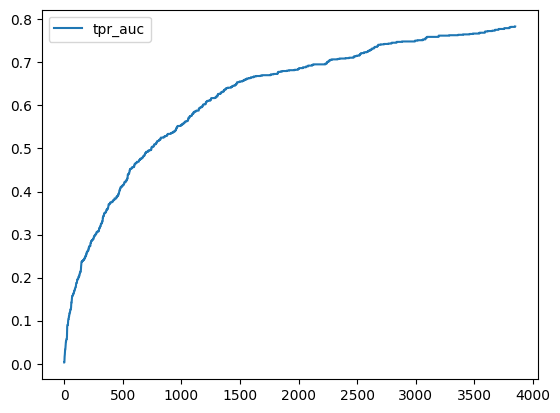

In [13]:
pd.DataFrame(tpr, columns=["tpr_auc"]).plot()